In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

seaborn   : 0.11.1
pandas    : 1.3.0
numpy     : 1.21.0
matplotlib: 3.4.2



In [2]:
from scipy import interpolate

# https://github.com/DaniRuizPerez/PALM-Public-Respository/blob/master/Alignment/getAlignmentsIBD_Taxa.py

#Use B-spline to extrapolate values. NOTE: Parameters s must be adjusted appropriately to avoid over-fitting.
# tck = interpolate.splrep(timepoints, relativeAbundances, k=3, s=0.001, xb=weekFirstSample, xe=weekLastSample)

In [3]:
SAMPLING_RATE = 1.0

In [4]:
df_mapping = pd.read_csv("../data/SampleID_map.txt", sep='\t', index_col=0)

In [5]:
# df_mapping

In [6]:
df_tax = pd.read_csv("../data/taxonomy_clr_s_top.txt", sep='\t', index_col=0)

In [7]:
df_tax_long = pd.melt(df_tax.reset_index(), id_vars=["#taxonomy"], value_vars=df_tax.columns, var_name="#SampleID")

df_tax_long = df_tax_long.rename({"#taxonomy": "feature"}, axis=1)

In [8]:
df_tax_metadata_long = pd.merge(df_tax_long, df_mapping.reset_index()[["#SampleID", "StudyDayNo", "UserName"]], on="#SampleID", how="left")

In [9]:
df_tax_metadata_long = df_tax_metadata_long.sort_values(["UserName", "feature", "StudyDayNo"])

In [10]:
taxonomy = 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_coli'

In [11]:
sample_ids = ["MCTs06", "MCTs10", "MCTs18", "MCTs37", "MCTs20"]
color_map = dict(zip(sample_ids, sns.color_palette("colorblind", 5)))

df_plot = df_tax_metadata_long.query(f"feature == '{taxonomy}'")
df_plot = df_plot.query("UserName in @sample_ids")

In [12]:
df_plot.to_csv("../data/plot_top.txt", sep="\t")

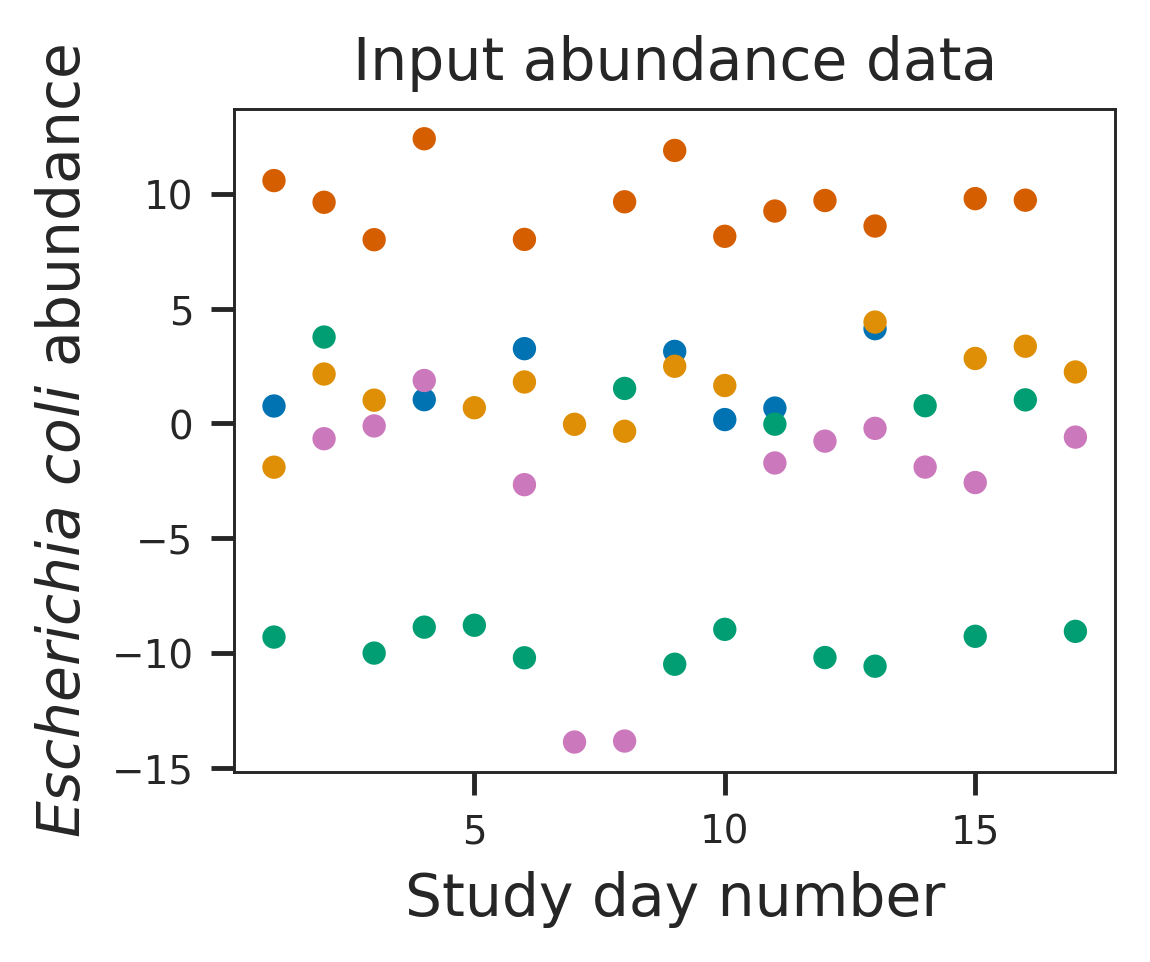

In [13]:
import plot_utils as pu
pu.figure_setup()


figsize = pu.get_fig_size(6.5 / 2)

fig, ax = plt.subplots(figsize=figsize)

sns.scatterplot(x="StudyDayNo", y="value",
                hue="UserName",
                sizes=(1, 8), linewidth=0,
                data=df_plot, ax=ax, palette=color_map)

legend = ax.legend()
handles = [_ for _ in legend.legendHandles]

ax.set_ylabel("$Escherichia\\ coli$ abundance")
ax.set_xlabel("Study day number")

ax.set_title("Input abundance data")

legend.remove()

pu.save_plot(fig, "samples.no.transform")

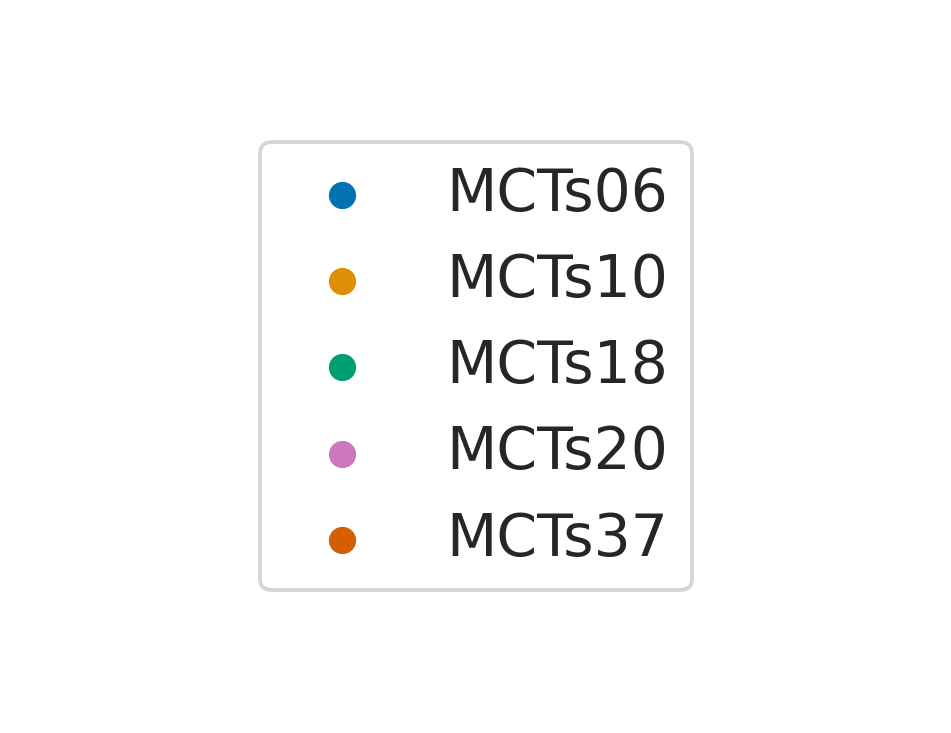

In [14]:
artists = ax.legend()

figsize = pu.get_fig_size(6.5 / 2)
fig, ax = plt.subplots(figsize=figsize)

_artists = ax.legend(loc="center", handles=artists.legendHandles)

plt.axis('off')
pu.save_plot(fig, f"samples.no.transform.legend", artists=(_artists,))

In [15]:
max_study_day_no = df_tax_metadata_long["StudyDayNo"].max()
min_study_day_no = df_tax_metadata_long["StudyDayNo"].min()

index_splines = np.arange(min_study_day_no, max_study_day_no + 1, SAMPLING_RATE, dtype="int")

# for group, df in df_tax_metadata_long.groupby(["UserName", "#taxonomy"]):
#     break

In [16]:
def yield_df_spline(username, taxonomy, df, index_splines, sampling_rate):
    
    timepoints = df["StudyDayNo"].values
    values = df["value"].values
#     print("hi")
    max_subj_study_day_no = df["StudyDayNo"].max()
    min_subj_study_day_no = df["StudyDayNo"].min()
    
    sd_subj_value = df["value"].std()

    max_subj_value = df["value"].max() + 2*sd_subj_value
    min_subj_value = df["value"].min() - 2*sd_subj_value
    
    if values.shape[0] > 3:
        spline = interpolate.splrep(timepoints, values, k=3, xb=min_subj_study_day_no, xe=max_subj_study_day_no)
    else:
        spline = interpolate.splrep(timepoints, values, k=1, xb=min_subj_study_day_no, xe=max_subj_study_day_no)
        
    spline_timepoints = np.arange(min_subj_study_day_no, max_subj_study_day_no + 1, sampling_rate, dtype='int')
    spline_values = interpolate.splev(spline_timepoints, spline)

    df_out = df.copy().set_index("StudyDayNo").reindex(index_splines)

    df_out['spline'] = pd.Series(spline_values, index=spline_timepoints)
#     df_out['spline'] = df_out['spline'].ffill().bfill()

    df_out['spline'] = np.clip(df_out['spline'], min_subj_value, max_subj_value)

    df_out["UserName"] = username
    df_out["feature"] = taxonomy
#     print("hi")
    return df_out, spline, username, taxonomy, min_subj_value, max_subj_value

In [17]:
# results = []
# for (username, taxonomy), df in df_tax_metadata_long.groupby(["UserName", "feature"]):
#     results.append(yield_df_spline(username, taxonomy, df, index_splines, SAMPLING_RATE))

In [18]:
import multiprocessing
pool = multiprocessing.Pool(24)
results = pool.starmap(yield_df_spline, [(username, taxonomy, df, index_splines, SAMPLING_RATE) for (username, taxonomy), df in df_tax_metadata_long.groupby(["UserName", "feature"])])

In [19]:
df_tax_splines = pd.concat([_[0] for _ in results])

In [20]:
from collections import defaultdict

d_splines = defaultdict(dict)
for (df, spline, username, taxonomy, c_min, c_max) in results:
    d_splines[username][taxonomy] = spline, c_min, c_max

In [21]:
df_tax_splines.to_csv("../results/tax_clr_splines.csv")

In [22]:
import pickle
with open("../results/d_splines.pkl", "wb") as outf:
    pickle.dump(d_splines, outf)

In [23]:
# now do kegg splines
df_kegg = pd.read_csv("../data/kegg_clr.txt", sep='\t', index_col=0)

df_kegg_long = pd.melt(df_kegg.reset_index(), id_vars=["#kegg"], value_vars=df_kegg.columns, var_name="#SampleID")

df_kegg_long = df_kegg_long.rename({"#kegg": "feature"}, axis=1)

In [24]:
df_kegg_metadata_long = pd.merge(df_kegg_long, df_mapping.reset_index()[["#SampleID", "StudyDayNo", "UserName"]], on="#SampleID", how="left")

In [25]:
df_kegg_metadata_long = df_kegg_metadata_long.sort_values(["UserName", "feature", "StudyDayNo"])

In [26]:
results = pool.starmap(yield_df_spline, [(username, taxonomy, df, index_splines, SAMPLING_RATE) for (username, taxonomy), df in df_kegg_metadata_long.groupby(["UserName", "feature"])])

In [27]:
df_kegg_splines = pd.concat([_[0] for _ in results])

In [28]:
d_splines = defaultdict(dict)
for (df, spline, username, taxonomy, c_min, c_max) in results:
    d_splines[username][taxonomy] = spline, c_min, c_max

In [29]:
df_kegg_splines.to_csv("../results/kegg_clr_splines.csv")

In [30]:
with open("../results/d_kegg_splines.pkl", "wb") as outf:
    pickle.dump(d_splines, outf)

In [31]:
# now do food splines
df_food = pd.read_csv("../data/food_clr_L3.txt", sep='\t', index_col=0)

df_food_long = pd.melt(df_food.reset_index(), id_vars=["#taxonomy"], value_vars=df_food.columns, var_name="#SampleID")

df_food_long = df_food_long.rename({"#taxonomy": "feature"}, axis=1)

In [32]:
df_food_metadata_long = pd.merge(df_food_long, df_mapping.reset_index()[["#SampleID", "StudyDayNo", "UserName"]], on="#SampleID", how="left")

In [33]:
df_food_metadata_long = df_food_metadata_long.sort_values(["UserName", "feature", "StudyDayNo"])

In [34]:
results = pool.starmap(yield_df_spline, [(username, taxonomy, df, index_splines, SAMPLING_RATE) for (username, taxonomy), df in df_food_metadata_long.groupby(["UserName", "feature"])])

In [35]:
df_food_splines = pd.concat([_[0] for _ in results])

In [36]:
d_splines = defaultdict(dict)
for (df, spline, username, taxonomy, c_min, c_max) in results:
    d_splines[username][taxonomy] = spline, c_min, c_max

In [37]:
df_food_splines.to_csv("../results/food_L3_clr_splines.csv")

In [38]:
with open("../results/d_food_splines.pkl", "wb") as outf:
    pickle.dump(d_splines, outf)

In [39]:
# now do nutrition splines
df_nutrients = pd.read_csv("../data/nutrients_top.txt", sep='\t', index_col=0)

df_nutrients_long = pd.melt(df_nutrients.reset_index(), id_vars=["#taxonomy"], value_vars=df_nutrients.columns, var_name="#SampleID")

df_nutrients_long = df_nutrients_long.rename({"#taxonomy": "feature"}, axis=1)

In [40]:
df_nutrients_metadata_long = pd.merge(df_nutrients_long, df_mapping.reset_index()[["#SampleID", "StudyDayNo", "UserName"]], on="#SampleID", how="left")

In [41]:
df_nutrients_metadata_long = df_nutrients_metadata_long.sort_values(["UserName", "feature", "StudyDayNo"])

In [42]:
results = pool.starmap(yield_df_spline, [(username, taxonomy, df, index_splines, SAMPLING_RATE) for (username, taxonomy), df in df_nutrients_metadata_long.groupby(["UserName", "feature"])])

In [43]:
df_nutrients_splines = pd.concat([_[0] for _ in results])

In [44]:
d_splines = defaultdict(dict)
for (df, spline, username, taxonomy, c_min, c_max) in results:
    d_splines[username][taxonomy] = spline, c_min, c_max

In [45]:
df_nutrients_splines.to_csv("../results/nutrients_splines.csv")

In [46]:
with open("../results/d_nutrient_splines.pkl", "wb") as outf:
    pickle.dump(d_splines, outf)